In [1]:
%pylab inline
import cv2

kernel3 = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
kernel5 = array([[0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0.]],dtype=np.uint8)
def segment_cells(gray,kernel,offset=-20):
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,101,offset)

    # noise removal
    clean = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    clean = cv2.morphologyEx(clean,cv2.MORPH_CLOSE,kernel, iterations = 2)
    Stats=cv2.connectedComponentsWithStats(thresh)
    return Stats

Populating the interactive namespace from numpy and matplotlib


In [82]:
def _imshow(image):
    figure(figsize=(15,15))
    imshow(image,cmap='gray')

In [83]:
# compute boundaries
def mark_boundaries(segmentation,tile):
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
    clean=np.array((segmentation>0)*255,dtype=np.uint8)
    bigger = cv2.dilate(clean,kernel,iterations=1)
    smaller = cv2.erode(clean,kernel,iterations=1)
    smaller = np.uint8(smaller)
    borders = cv2.subtract(bigger,smaller)
    borders3=np.multiply.outer(borders,np.array([0,1,0],dtype=np.uint8))
    marked_tile=tile.copy()
    marked_tile[borders3>0]=np.max(marked_tile.flatten())
    figure(figsize=(15,15))
    imshow(marked_tile)

CPU times: user 29.4 ms, sys: 33.9 ms, total: 63.3 ms
Wall time: 57.5 ms


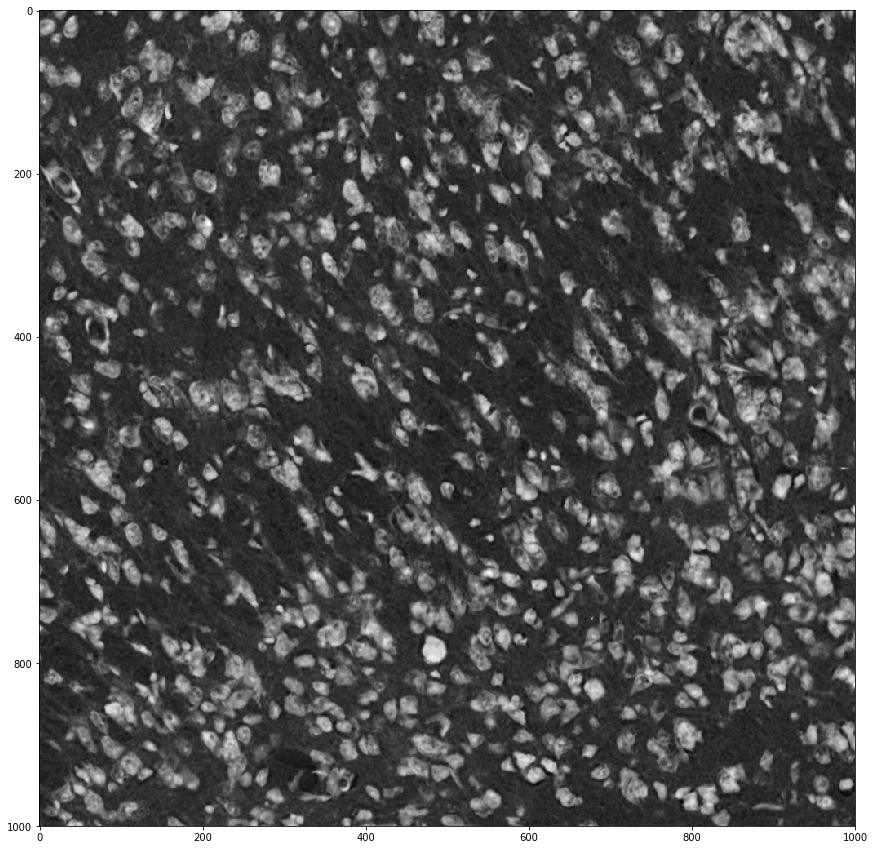

In [88]:
%%time
tile=imread('../../../data/tiles/tiles_365.tif')
gray = -cv2.cvtColor(tile,cv2.COLOR_BGR2GRAY)
_imshow(gray)

In [89]:

Stats = segment_cells(gray)

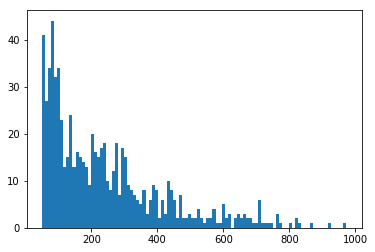

In [90]:
sizes=Stats[2][1:,-1]
hist(sizes[((sizes<1000) & (sizes>50))],bins=100);

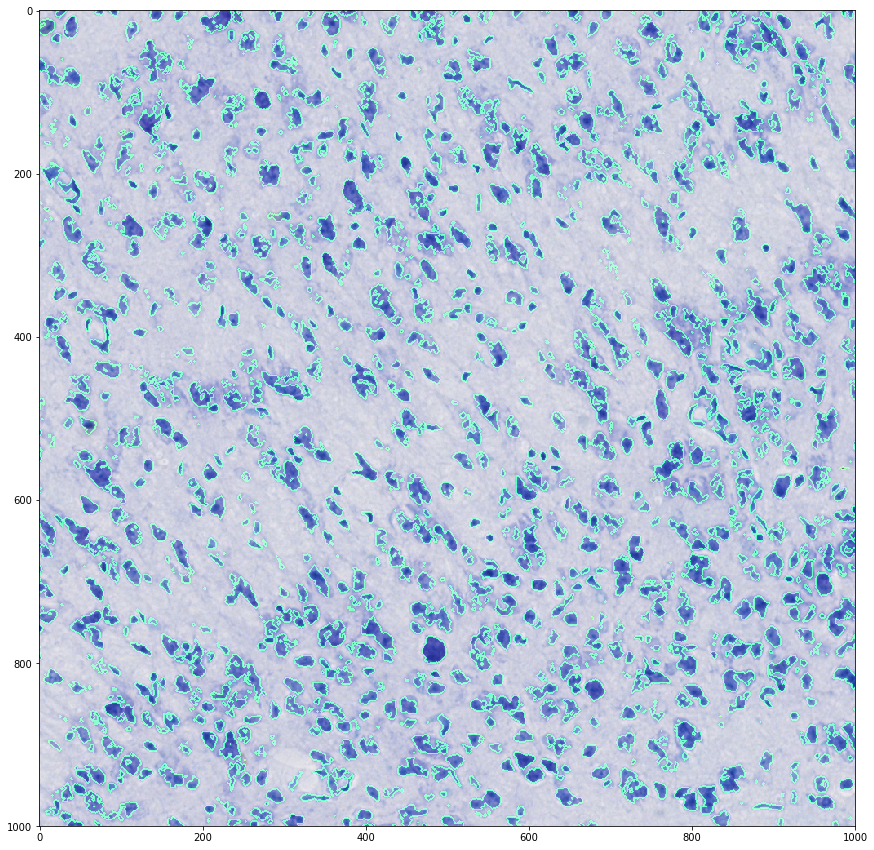

In [91]:
mark_boundaries(Stats[1],tile)

In [ ]:
%%time 
count_marks=None
for offset in Stats.keys():
    mask=np.array(1.*(Stats[offset][1]>0),dtype=np.uint8)
    if count_marks is None:
        count_marks = mask
    else:
        count_marks += mask
#hist(count_marks.flatten())
#figure(figsize=[15,15])
#imshow(count_marks>0)

        
min_marks=3
foci=np.array(1*(count_marks>min_marks),dtype=uint8)
foci_no_comp,foci_markers,foci_stats,foci_centroids = cv2.connectedComponentsWithStats(foci)

print('foci_no_comp=',foci_no_comp)

def pixel_XY(markers,mark_no):
    return np.nonzero(markers==mark_no)
def reverse_dict(markers):
    markers_no=np.max(markers.flatten())
    reverse={}
    for mark_no in range(1,markers_no):
        X,Y=pixel_XY(markers,mark_no)
        for i in range(X.shape[0]):
            reverse[(X[i],Y[i])]=mark_no
    return reverse
reverse=reverse_dict(foci_markers)
print('length of reverse dictionary=',len(reverse))

In [ ]:
def add2DictOfSets(Dict,key,value):
    """ Add value to a set of values associated with key"""
    if key in Dict:
        Dict[key].add(value)
    else:
        Dict[key]=set([value])
        

In [ ]:
%%time
foci2markers={}  # maps each foci to the set of markers that contain it
markers2foci={}  # maps each marker to the set of foci it contains.
for offset in Stats.keys():
    no_comp,markers,stats,centroids=Stats[offset]
    for mark_no in range(1,no_comp):
        X,Y = pixel_XY(markers,mark_no)
        print('\roffset=',offset,'mark_no=',mark_no,'X.len=',X.shape[0],end="")
        for i in range(5,X.shape[0]):
            if (X[i],Y[i]) in reverse:
                focus = reverse[(X[i],Y[i])]
                add2DictOfSets(foci2markers,focus,(offset,mark_no))
                add2DictOfSets(markers2foci,(offset,mark_no),focus)
                
len(foci2markers),len(markers2foci)

In [ ]:
import pickle as pk
pk.dump({'foci2markers':foci2markers,
        'markers2foci':markers2foci},
       open('focimarkers.pkl','wb'))

In [ ]:
i=0
stacks={}
for foci in foci2markers.keys():
    marker_stack=list(foci2markers[foci])
    marker_stack=sorted(marker_stack,key=lambda x:x[0])
    marker_stack_size=[]
    for offset,mark_no in marker_stack:
        size=Stats[offset][2][mark_no,-1]
        marker_stack_size.append((offset,mark_no,size))
    stacks[foci]=marker_stack_size
    if i%10 == 0:
        print('\r',i,foci,end='') #marker_stack_size)
    #if (i>5):
    #    break
    i+=1

In [ ]:
i=1
offsets=Stats.keys()
figure(figsize=(15,60))
print('number of foci=',np.max(list(stacks.keys())))

for foci in sorted(stacks.keys()):
    #print(foci,stacks[foci])
    L=stacks[foci]
    size={}

    for offset in offsets:
        size[offset]=np.sum([x[2] for x in L if x[0]==offset])
        if size[offset]>2000:
            size[offset]=2000
    sizes=np.array([size[offset] for offset in offsets])

    #print(sizes)
    if sizes[-1]<100:
        continue
    subplot(20,5,i)
    i+=1
    relsizes = sizes
    plot(offsets,sizes)
    deltas=[0]+list((sizes[1:]-sizes[:-1]))
    plot(offsets,deltas)
    title('%1d:%4d'%(foci,sizes[-1]))
    ylim([0,2000])
    grid()
    if i%10 == 0:
        print('\r',i,end='')
    if i>100:
        break

In [ ]:
for foci in [295]:
    print(foci,stacks[foci])
    L=stacks[foci]
    offsets=range(-40,0)
    size={}
    for offset in offsets:
        size[offset]=np.sum([x[2] for x in L if x[0]==offset])
    sizes=[size[offset] for offset in offsets]
    plot(offsets,sizes)
    title(str(foci))


In [ ]:
S=Stats[-20]
marker1=1*(Stats[-10][1]==207)
marker2=1*(Stats[-5][1]==146)
#marker3=1*(Stats[-3][1]==423)

figure(figsize=(15,15))
mask=np.multiply.outer((marker2+1),np.array([1,1,1],dtype=np.uint8))
imshow(mask*tile) #marker1+marker2+

In [ ]:
cleaned_mask=np.array(1.*(Stats[-20][1]>0),dtype=np.uint8)
mark_boundaries(cleaned_mask,tile)

In [ ]:
print('no of components=',no_comp)
figure(figsize=(10,10))
markers=markers+1
#markers[markers>=255]=0
imshow(markers);

In [ ]:
markers2=markers.copy()
watershed=cv2.watershed(gray3,markers2)
figure(figsize=[10,10])
imshow(watershed);

np.max(markers.flatten())

gray3=np.multiply.outer(gray,np.array([1,1,1],dtype=np.uint8))
_imshow(gray3)

hist(gray3.flatten());